In [101]:
# inpath = 'tablellama'
# inpath = 'gemma2-9b'
inpath = 'gemma2-2b'

In [102]:
import torch
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
from tqdm import tqdm
import gc
import pandas as pd
import seaborn as sns
import pickle
import math
from IPython.display import clear_output
import numpy as np
import re
import os

sns.set_context("notebook", font_scale=1.25)
 
file_path = "turl_test_2k_prompts_50_unique.jsonl"
device = torch.device("mps")

In [103]:
outlist = []

for single_file in os.listdir(inpath):
    if 'aggregated' in single_file and 'pickle' in single_file:
        with open(os.path.join(inpath, single_file), 'rb') as handle:
            myfile = pickle.load(handle)
            temperature = single_file.split('_')[-1][:3]
            myfile['temp'] = temperature
            outlist.append(myfile)

In [104]:
d = pd.concat(outlist)

In [105]:
d

,pid,answer_clean,cand_clean,regex_match_clean,num_answers,answers_freqs,answers_entropy,answers_entropy_norm,regex_match_freqs,regex_match_entropy,regex_match_entropy_norm,correct,temp
0,13,[penalty recordings american record label reco...,"[, '- and , '-deuterium-labeled dopamine. syn...",[penalty recordings american record label reco...,3,"[6, 3, 1]",0.897946,0.566541,"[7, 3]",0.610864,0.610864,0.6,1.2
1,14,[sony discos us record label; imprint of sony ...,[sony movie channel american movie-oriented te...,"[None, None, None, None, None, None, None, Non...",4,"[7, 1, 1, 1]",0.940448,0.470224,[10],0.000000,0.000000,0.0,1.2
2,17,"[huánuco distric, huánuco distric, huánuco reg...",[predefinição:futebol león de huánuco wikimedi...,"[None, None, None, None, None, None, None, Non...",4,"[7, 1, 1, 1]",0.940448,0.470224,[10],0.000000,0.000000,0.0,1.2
3,19,"[fitzroy parish of vernon county, new south wa...",[fitzroy former state electoral district of qu...,"[None, None, None, None, None, None, None, Non...",7,"[1, 1, 3, 2, 1, 1, 1]",1.834372,0.653416,[10],0.000000,0.000000,0.0,1.2
4,41,[augustinian canons order of the catholic chur...,[independent augustinian communities none none...,"[None, None, None, None, None, None, None, Non...",6,"[1, 2, 4, 1, 1, 1]",1.609438,0.622616,[10],0.000000,0.000000,0.0,1.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,1752,"[ilmer village in buckinghamshire, united king...","[walther ilmer none human, ilmer höhe hill in ...","[ilmer village in buckinghamshire, united king...",5,"[6, 1, 1, 1, 1]",1.227529,0.528668,[10],0.000000,0.000000,0.6,1.7
204,1764,"[**2013 boston red sox season**[ \n* [desc],\n...",[carolina mudcats minor league baseball team b...,"[None, boston red sox baseball team and major ...",9,"[1, 2, 1, 1, 1, 1, 1, 1, 1]",2.163956,0.682652,"[6, 4]",0.673012,0.673012,0.2,1.7
205,1779,[2008–09 melbourne victory w-league season des...,[2017–18 melbourne victory fc season season of...,"[None, None, None, None, None, None, None, Non...",10,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",2.302585,0.693147,[10],0.000000,0.000000,0.0,1.7
206,1786,"[indian national congres, indian national cong...",[indian youth congress youth wing of the india...,"[None, indian national congress indian politic...",7,"[1, 2, 1, 1, 1, 2, 2]",1.886697,0.672055,"[8, 2]",0.500402,0.500402,0.2,1.7


In [106]:
d.groupby('temp').size()

temp
0.1    208
0.2    208
0.3    208
0.4    208
0.5    208
0.6    208
0.7    208
0.8    208
0.9    208
1.0    208
1.1    208
1.2    208
1.3    208
1.4    208
1.5    208
1.6    208
1.7    208
1.8    208
1.9    208
2.0    208
dtype: int64

In [107]:
d = d.sort_values(by=['temp', 'pid'])
d = d.rename(columns={'temp':'temperature'})

In [108]:
d.temperature = d.temperature.replace({'1.p': 1.0})
d.temperature = d.temperature.astype(float)

<Axes: xlabel='temperature', ylabel='answers_entropy_norm'>

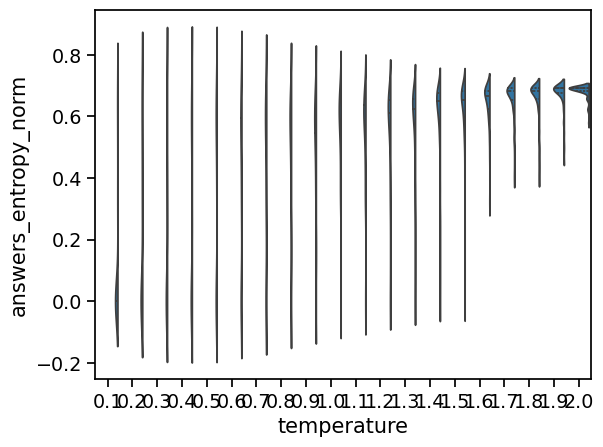

In [109]:
sns.violinplot(data=d, x="temperature", y="answers_entropy_norm", split=True, inner="quart")

<Axes: xlabel='temperature', ylabel='num_answers'>

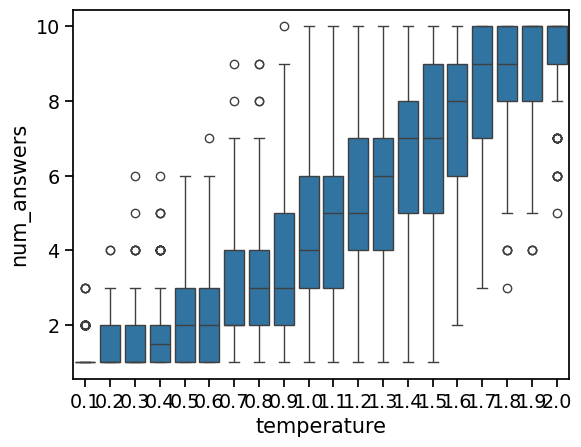

In [110]:
sns.boxplot(data=d, x="temperature", y="num_answers")

<Axes: xlabel='temperature', ylabel='answers_entropy_norm'>

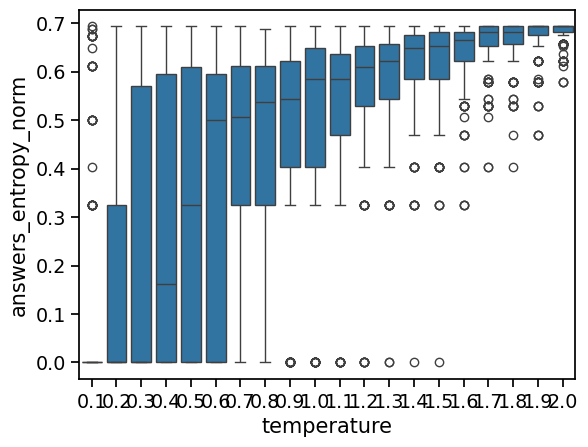

In [111]:
sns.boxplot(data=d, x="temperature", y="answers_entropy_norm")

<Axes: xlabel='temperature', ylabel='correct'>

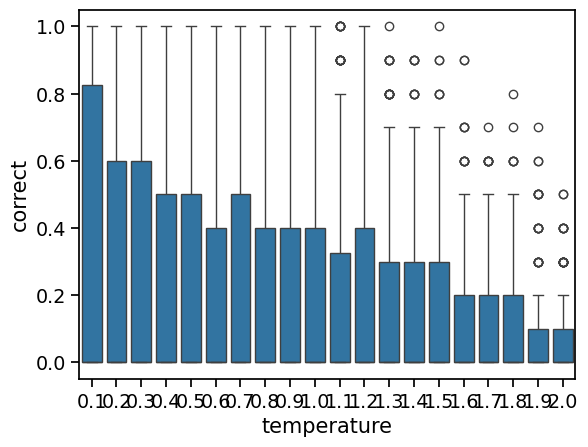

In [112]:
sns.boxplot(data=d, x="temperature", y="correct")

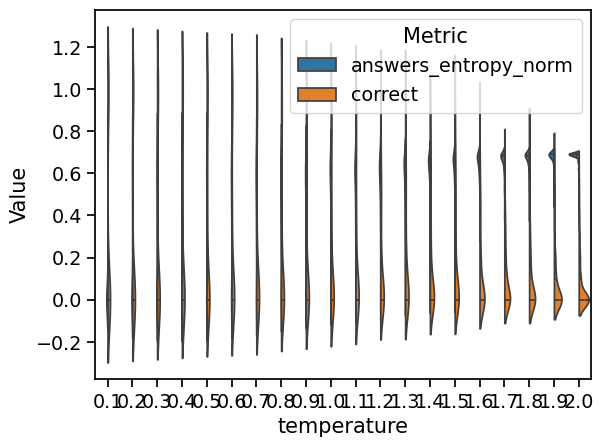

In [113]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


d_melted = pd.melt(d, id_vars=["temperature"], value_vars=["answers_entropy_norm", "correct"],
                   var_name="Metric", value_name="Value")

sns.violinplot(data=d_melted, x="temperature", y="Value", hue="Metric", split=True, inner="quart")

plt.show()

/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_14720/2571452054.py:12: UserWarning: The palette list has more values (9) than needed (2), which may not be intended.
  sns.violinplot(
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_14720/2571452054.py:12: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(


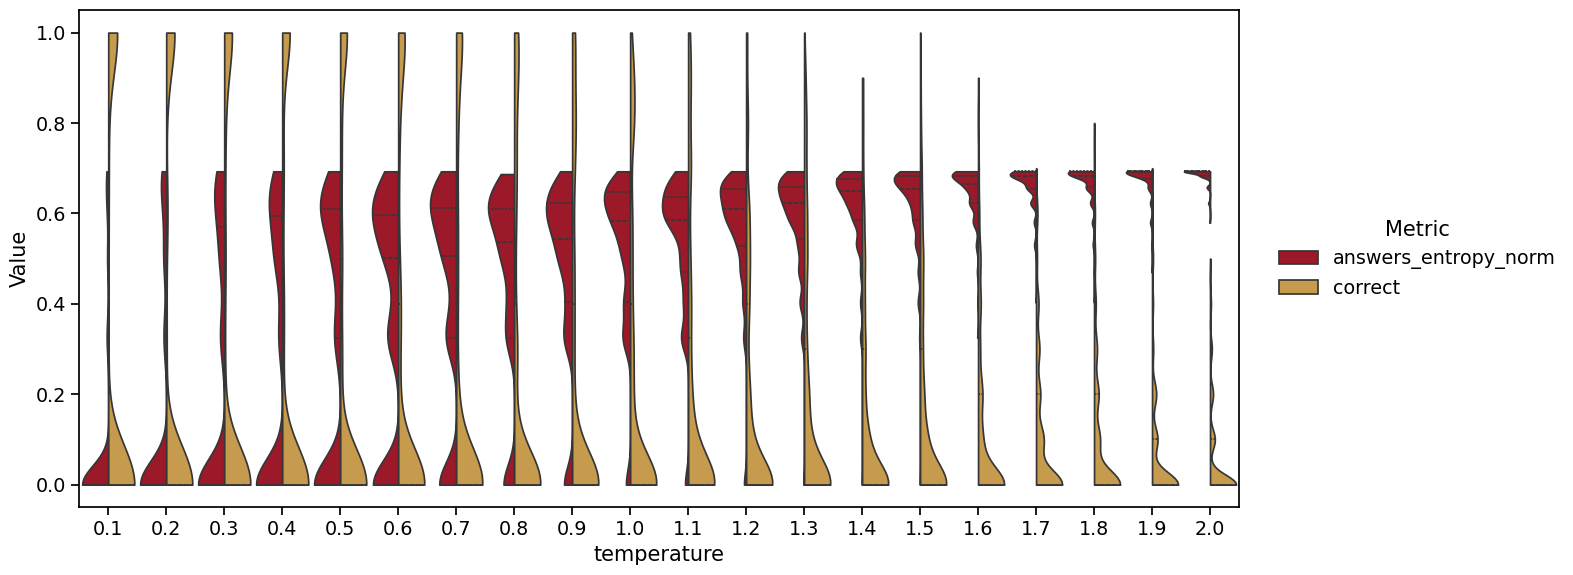

In [114]:
from palettable.cartocolors.qualitative import Prism_10, Bold_10, Bold_7
from palettable.tableau import TrafficLight_9, BlueRed_12
palette = TrafficLight_9.mpl_colors

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming `d_melted` is already created
plt.figure(figsize=(16, 6))

sns.violinplot(
    data=d_melted,
    x="temperature",
    y="Value",
    hue="Metric",
    split=True,
    inner="quart",
    density_norm="count",
    cut=0,
    bw=0.2,
    width=0.9,
    palette=palette
)

plt.legend(
    title="Metric",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False
)

plt.tight_layout()  # Adjust layout so things don't overlap
plt.show()

/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_14720/1464094971.py:13: UserWarning: The palette list has more values (9) than needed (2), which may not be intended.
  sns.boxplot(


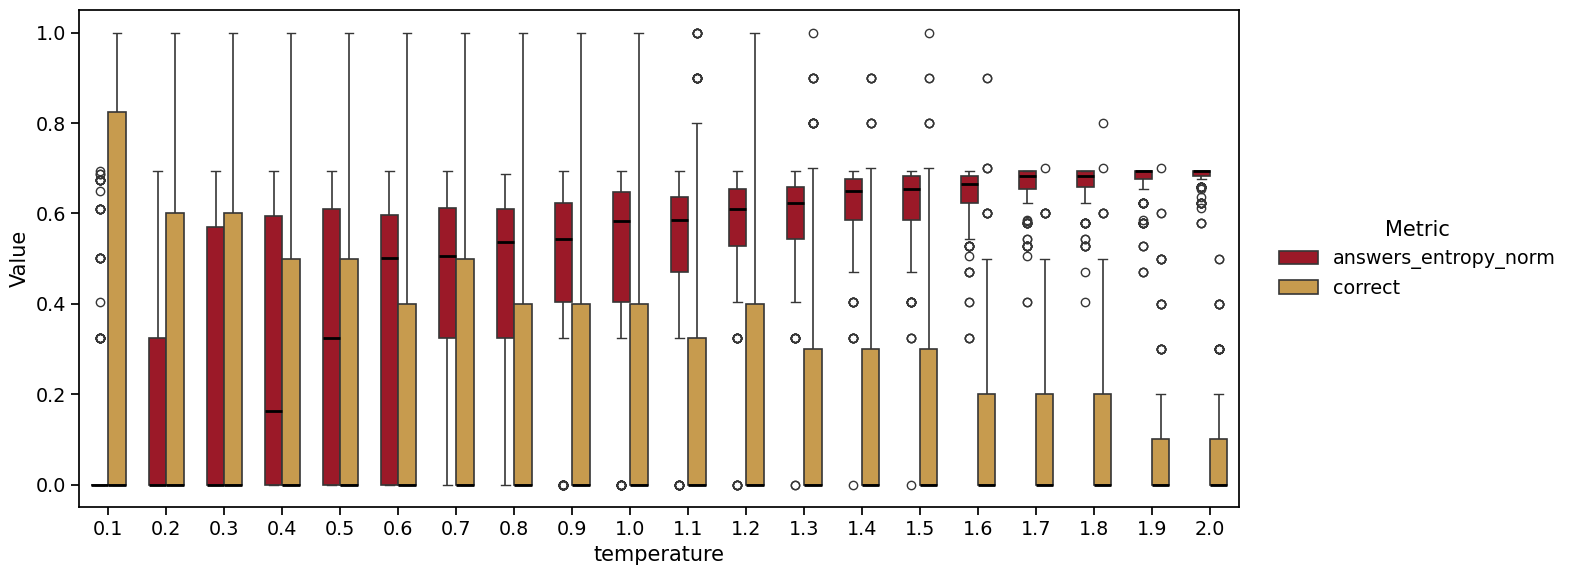

In [115]:
from palettable.tableau import TrafficLight_9
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Palette
palette = TrafficLight_9.mpl_colors

# Create figure
plt.figure(figsize=(16, 6))

# Boxplot instead of violinplot
sns.boxplot(
    data=d_melted,
    x="temperature",
    y="Value",
    hue="Metric",
    palette=palette,
    width=0.6,          # Width of the boxes
    dodge=True,         # Separates boxes by hue
    showcaps=True,      # Show caps
    boxprops={"linewidth": 1.2},
    whiskerprops={"linewidth": 1.2},
    medianprops={"color": "black", "linewidth": 2},
)

# Legend outside, without frame
plt.legend(
    title="Metric",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False
)

plt.tight_layout()
plt.show()

In [116]:
d.temperature.value_counts()

temperature
0.1    208
0.2    208
1.9    208
1.8    208
1.7    208
1.6    208
1.5    208
1.4    208
1.3    208
1.2    208
1.1    208
1.0    208
0.9    208
0.8    208
0.7    208
0.6    208
0.5    208
0.4    208
0.3    208
2.0    208
Name: count, dtype: int64

In [117]:
d[d.temperature=='0.1'].correct.value_counts(normalize=True)

Series([], Name: proportion, dtype: float64)

In [118]:
d[d.temperature=='0.1'].answers_entropy_norm.value_counts(normalize=True)

Series([], Name: proportion, dtype: float64)

In [119]:
d[d.temperature=='1.0'].correct.value_counts(normalize=True)

Series([], Name: proportion, dtype: float64)

/Users/bono/miniforge3/envs/doubt/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (9) than needed (2), which may not be intended.
  func(*plot_args, **plot_kwargs)
/Users/bono/miniforge3/envs/doubt/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (9) than needed (2), which may not be intended.
  func(*plot_args, **plot_kwargs)
/Users/bono/miniforge3/envs/doubt/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (9) than needed (2), which may not be intended.
  func(*plot_args, **plot_kwargs)
/Users/bono/miniforge3/envs/doubt/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (9) than needed (2), which may not be intended.
  func(*plot_args, **plot_kwargs)
/Users/bono/miniforge3/envs/doubt/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (9) tha

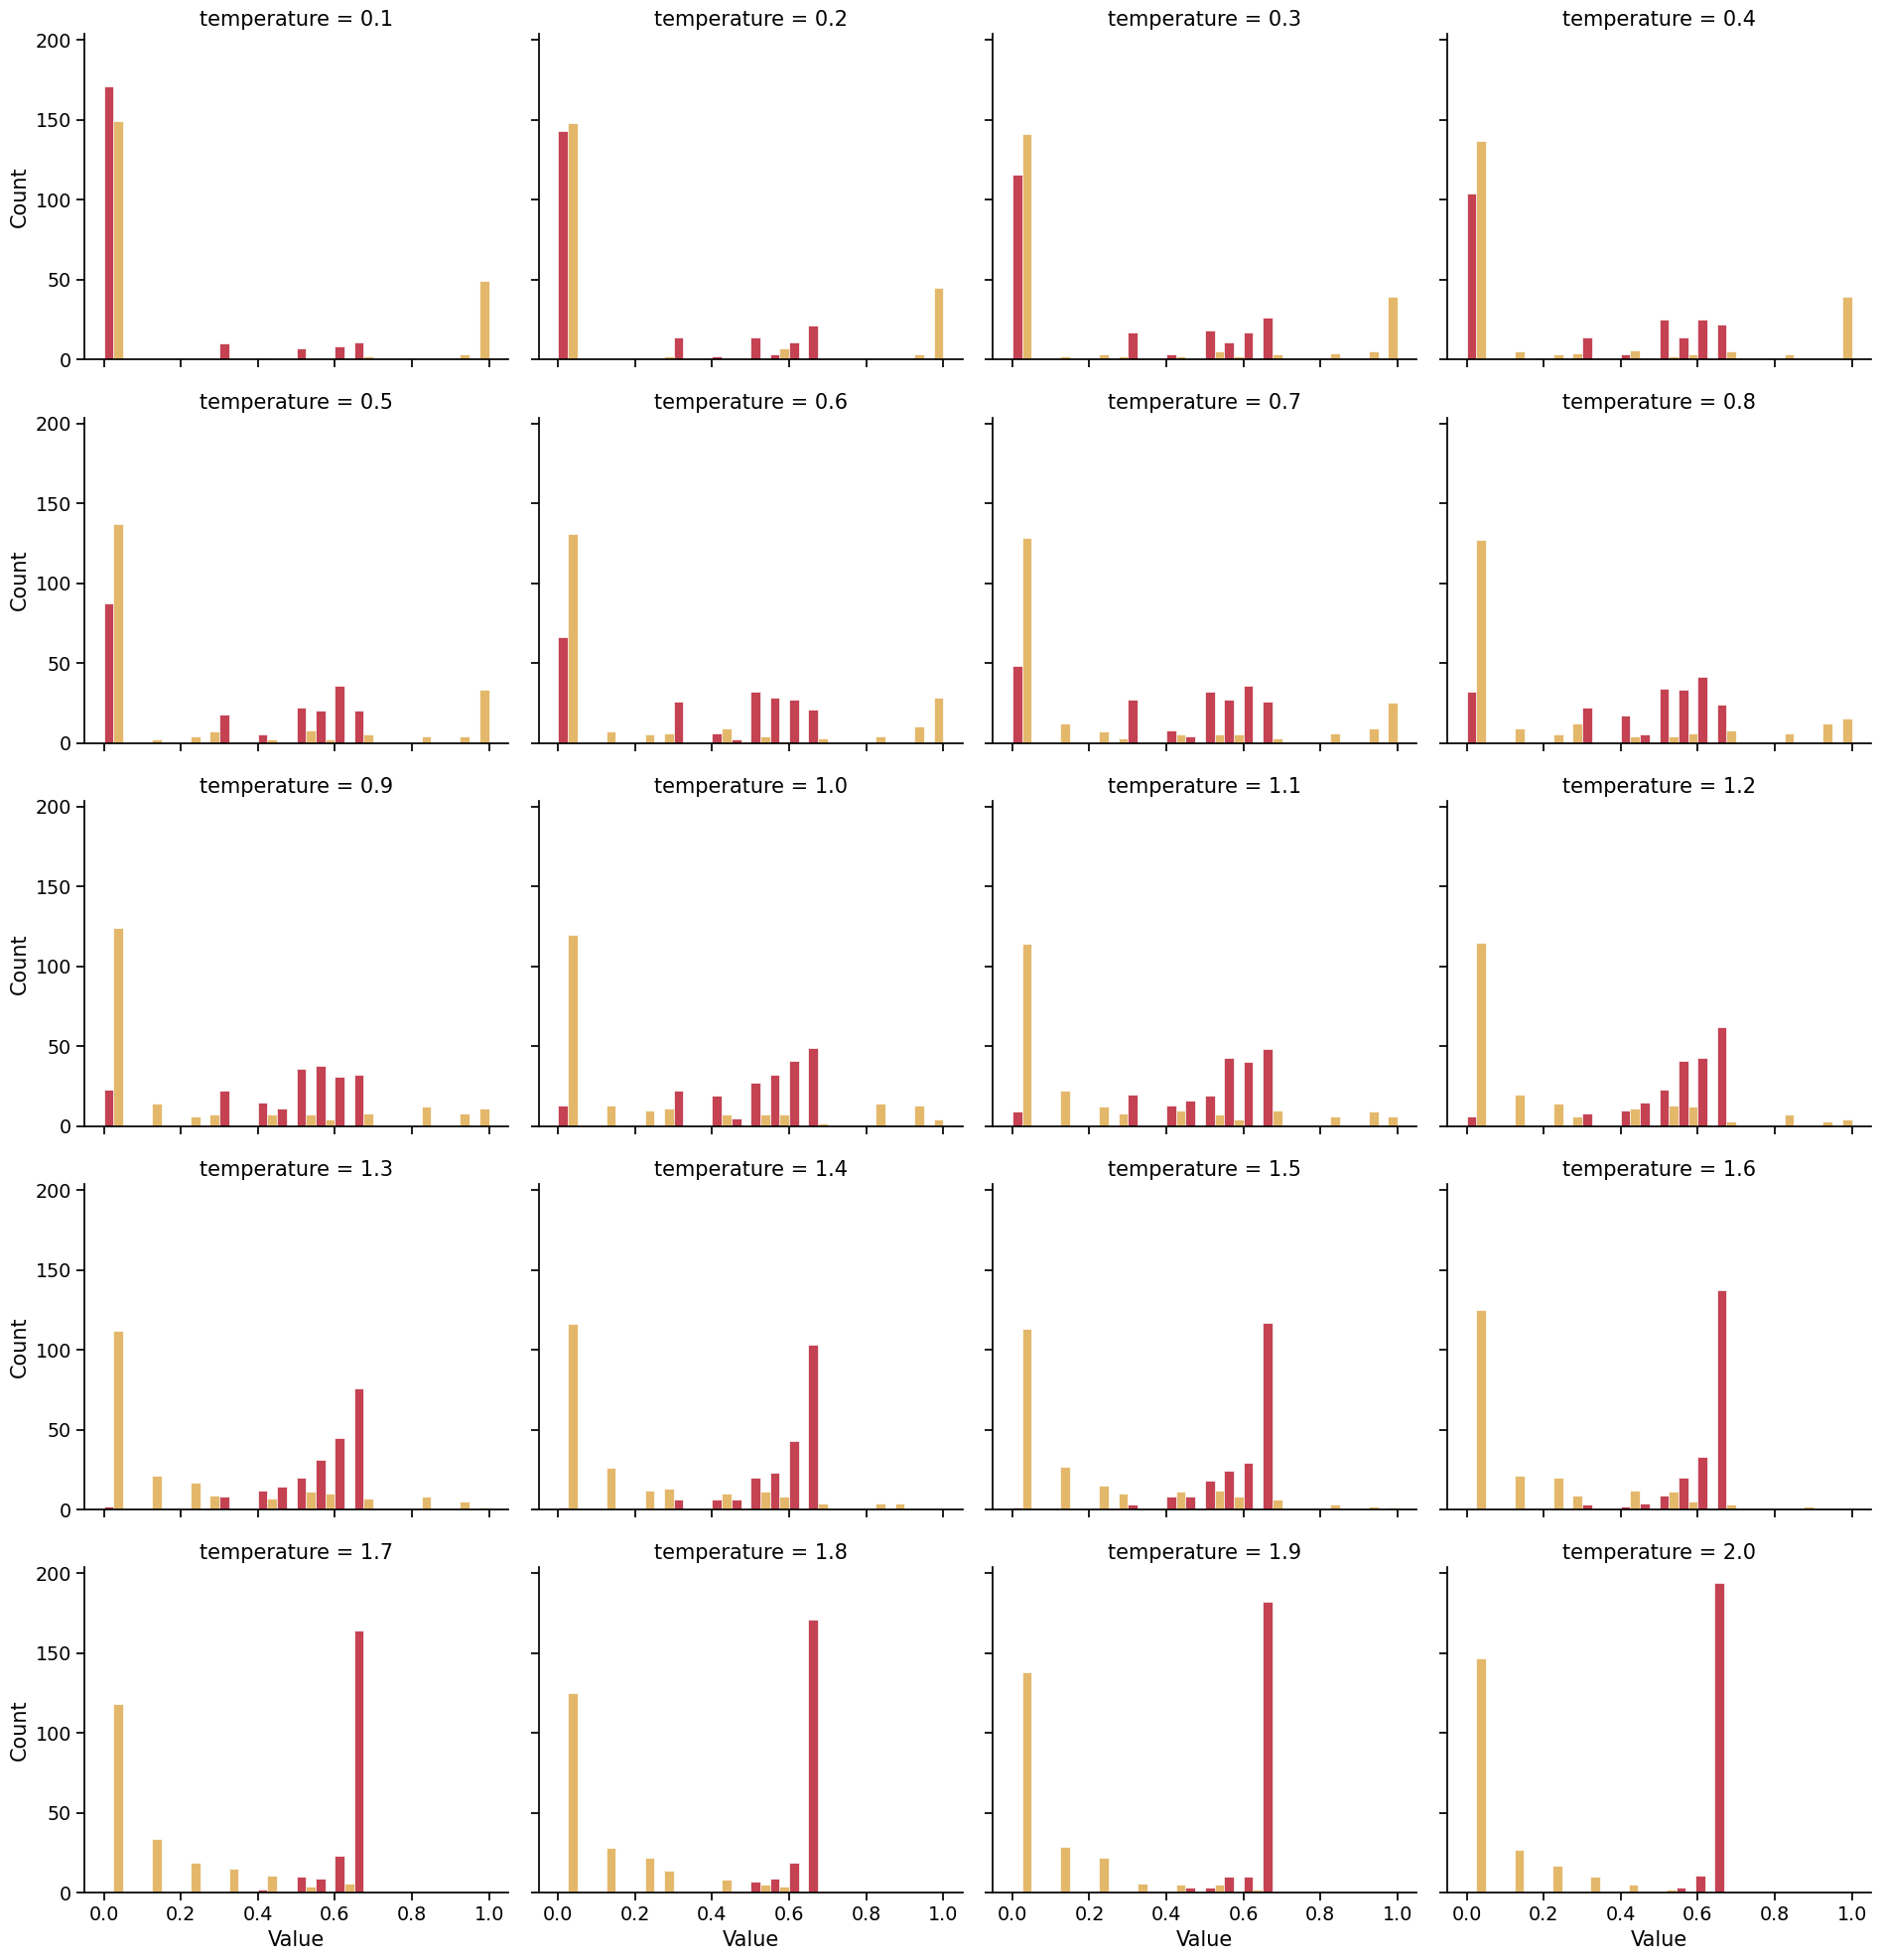

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt
from palettable.tableau import TrafficLight_9

palette = TrafficLight_9.mpl_colors

# Create FacetGrid for each temperature
g = sns.FacetGrid(
    d_melted,
    col="temperature",
    col_wrap=4,
    sharey=True,  # Share y-axis across all facets for consistent height
    height=4,
    aspect=1.2
)

# Map histplot onto each facet
g.map_dataframe(
    sns.histplot,
    x="Value",
    hue="Metric",
    multiple="dodge",  # Side-by-side bars
    palette=palette,
    binwidth=0.05,
    edgecolor="white",
    linewidth=0.5
)


# Tidy layout
plt.tight_layout()
plt.show()

### majority voting vs temperature

In [121]:
d['majority_correct'] = d.correct >= 0.5

In [122]:
d.groupby('temperature').majority_correct.sum()

temperature
0.1    57
0.2    56
0.3    58
0.4    53
0.5    56
0.6    50
0.7    53
0.8    51
0.9    50
1.0    47
1.1    42
1.2    42
1.3    42
1.4    31
1.5    32
1.6    21
1.7    11
1.8    11
1.9     8
2.0     2
Name: majority_correct, dtype: int64

In [123]:
d[d.correct==1.].groupby('temperature').correct.sum()

temperature
0.1    49.0
0.2    45.0
0.3    39.0
0.4    39.0
0.5    33.0
0.6    28.0
0.7    25.0
0.8    15.0
0.9    11.0
1.0     4.0
1.1     6.0
1.2     4.0
1.3     1.0
1.5     1.0
Name: correct, dtype: float64

In [124]:
d[d.correct==0.].groupby('temperature').correct.size()

temperature
0.1    149
0.2    148
0.3    141
0.4    137
0.5    137
0.6    131
0.7    128
0.8    127
0.9    124
1.0    120
1.1    114
1.2    115
1.3    112
1.4    116
1.5    113
1.6    125
1.7    118
1.8    125
1.9    138
2.0    147
Name: correct, dtype: int64

/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_14720/1399920576.py:25: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(


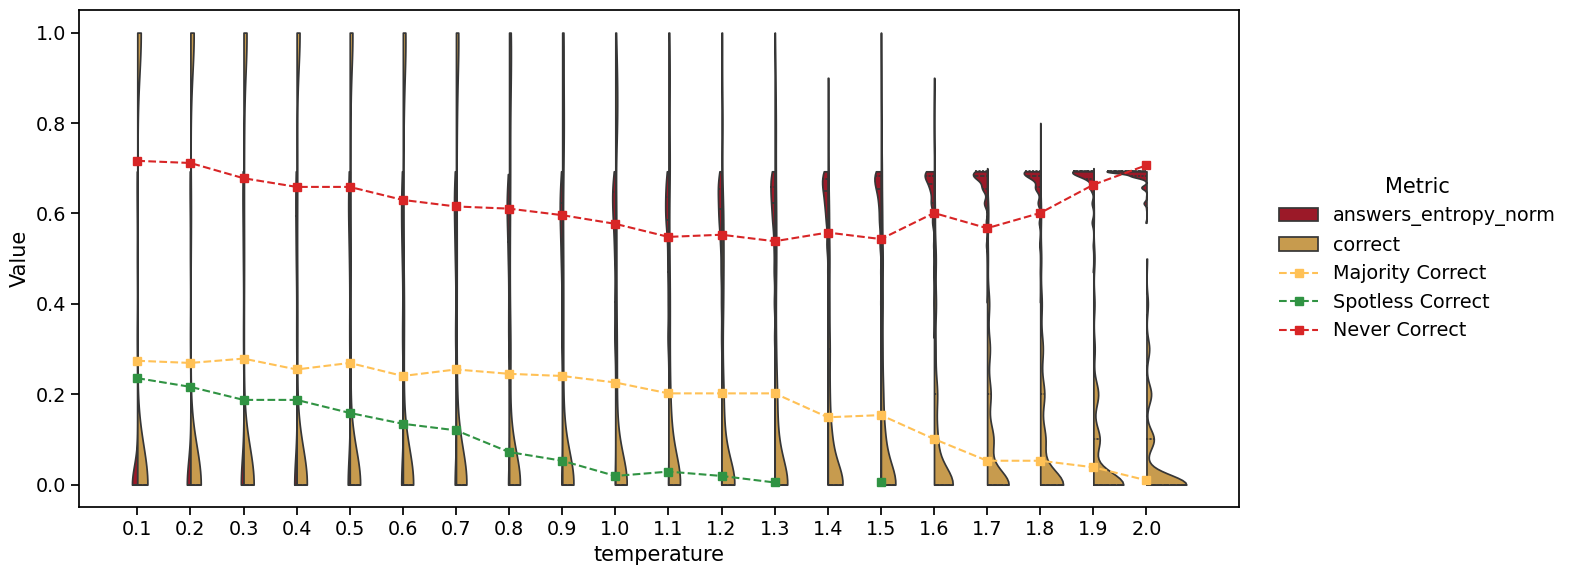

In [125]:
from palettable.tableau import TrafficLight_9
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

palette = TrafficLight_9.mpl_colors

# Normalize to 0–1
total_counts = d.groupby('temperature').size()
maj_correct_norm = d.groupby('temperature').majority_correct.sum() / total_counts
spotless_correct_norm = d[d.correct == 1.].groupby('temperature').correct.sum() / total_counts
never_correct_norm = d[d.correct==0.].groupby('temperature').correct.size() / total_counts

# Ensure consistent temperature order
temperature_order = sorted(d["temperature"].unique())
x_pos = range(len(temperature_order))

maj_vals = maj_correct_norm.reindex(temperature_order).values
spot_vals = spotless_correct_norm.reindex(temperature_order).values
never_vals = never_correct_norm.reindex(temperature_order).values

# Plot
plt.figure(figsize=(16, 6))

sns.violinplot(
    data=d_melted,
    x="temperature",
    y="Value",
    hue="Metric",
    split=True,
    inner="quart",
    density_norm="area",
    cut=0,
    bw=0.2,
    width=1.5,
    palette=palette[:2]  # Use only first two for violin
)

# Overlay normalized summary lines
plt.plot(x_pos, maj_vals, marker='s', linestyle='--', color=palette[4], label='Majority Correct')
plt.plot(x_pos, spot_vals, marker='s', linestyle='--', color=palette[2], label='Spotless Correct')
plt.plot(x_pos, never_vals, marker='s', linestyle='--', color=palette[3], label='Never Correct')

# Set x-axis labels
plt.xticks(ticks=x_pos, labels=temperature_order)

# Combine legends
handles1, labels1 = plt.gca().get_legend_handles_labels()
plt.legend(
    handles=handles1,
    title="Metric",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False
)

plt.tight_layout()
plt.show()

In [126]:
d.columns

Index(['pid', 'answer_clean', 'cand_clean', 'regex_match_clean', 'num_answers',
       'answers_freqs', 'answers_entropy', 'answers_entropy_norm',
       'regex_match_freqs', 'regex_match_entropy', 'regex_match_entropy_norm',
       'correct', 'temperature', 'majority_correct'],
      dtype='object')

/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_14720/3108001628.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_14720/3108001628.py:31: UserWarning: 
The palette list has fewer values (1) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.violinplot(
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_14720/3108001628.py:31: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_14720/3108001628.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and wi

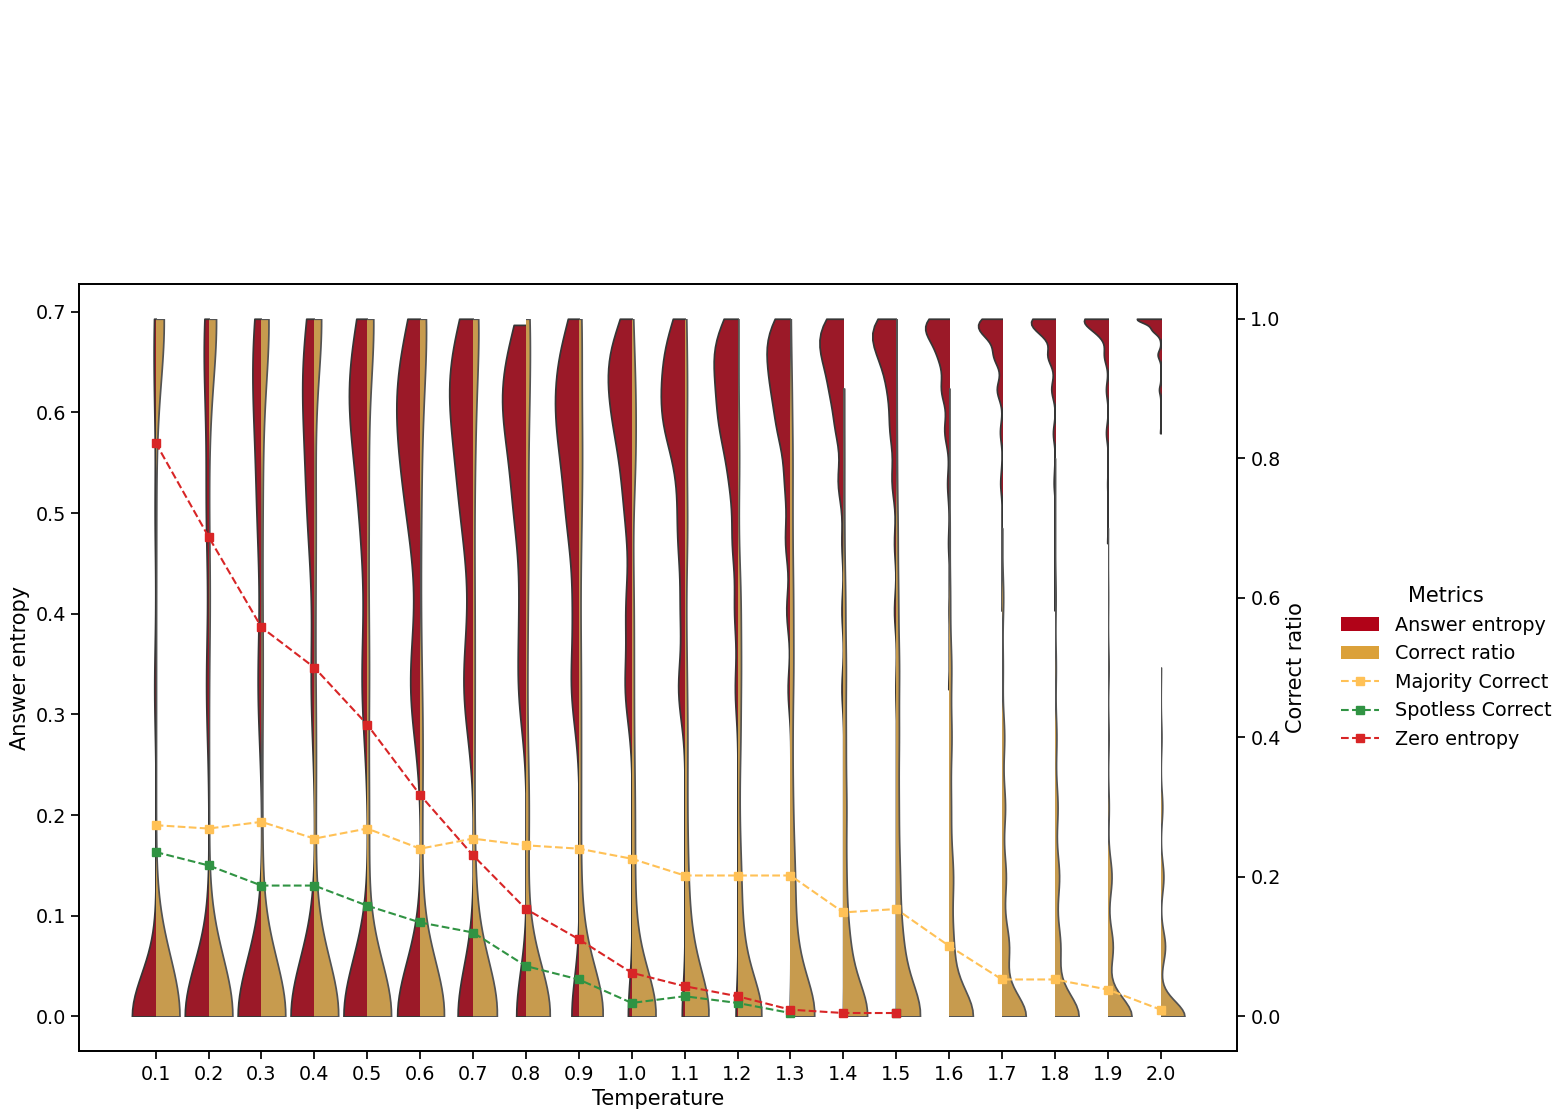

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from palettable.tableau import TrafficLight_9

palette = TrafficLight_9.mpl_colors

# Prepare the data
answers_data = d_melted[d_melted["Metric"] == "answers_entropy_norm"]

correct_data = d_melted[d_melted["Metric"] == "correct"]

# Summary lines
total_counts = d.groupby('temperature').size()
maj_vals = (d.groupby('temperature').majority_correct.sum() / total_counts).reindex(sorted(d["temperature"].unique())).values
spot_vals = (d[d.correct == 1.].groupby('temperature').correct.sum() / total_counts).reindex(sorted(d["temperature"].unique())).values
# never_vals = (d[(d.correct == 0.) & (d.answers_entropy_norm==0.)].groupby('temperature').correct.size() / total_counts).reindex(sorted(d["temperature"].unique())).values
never_vals = (d[(d.answers_entropy_norm==0.)].groupby('temperature').correct.size() / total_counts).reindex(sorted(d["temperature"].unique())).values

temperature_order = sorted(d["temperature"].unique())
x_pos = range(len(temperature_order))

# Set up figure and dual y-axes
fig, ax1 = plt.subplots(figsize=(16, 12))
ax2 = ax1.twinx()

# Half-width for manual split look
half_width = 0.9

# Plot left half (answers_entropy_norm)
sns.violinplot(
    data=answers_data,
    x="temperature",
    y="Value",
    order=temperature_order,
    ax=ax1,
    # inner="quart",
    inner = None,
    density_norm="width",
    cut=0,
    bw=0.2,
    width=half_width,
    palette=[palette[0]]
)

# Plot right half (correct), mirrored by negating the width and flipping
sns.violinplot(
    data=correct_data,
    x="temperature",
    y="Value",
    order=temperature_order,
    ax=ax2,
    inner=None,
    density_norm="width",
    cut=0,
    bw=0.2,
    width=half_width,
    palette=[palette[1]]
)

# Adjust each violin’s appearance by clipping the left or right half
# Seaborn plots violins as collections, we’ll mask them

# Shift and clip left (entropy) side
for i, artist in enumerate(ax1.collections):
    artist.set_clip_on(True)
    artist.set_clip_path(plt.Rectangle(
        (i - 0.5, 0), 0.5, 1.0, transform=ax1.transData
    ))  # Only left half

# Shift and clip right (correct) side
for i, artist in enumerate(ax2.collections):
    artist.set_clip_on(True)
    artist.set_clip_path(plt.Rectangle(
        (i, 0), 0.5, 1.0, transform=ax2.transData
    ))  # Only right half

# Overlay normalized lines
ax2.plot(x_pos, maj_vals, marker='s', linestyle='--', color=palette[4], label='Majority Correct')
ax2.plot(x_pos, spot_vals, marker='s', linestyle='--', color=palette[2], label='Spotless Correct')
ax2.plot(x_pos, never_vals, marker='s', linestyle='--', color=palette[3], label='Zero entropy')

# Axis formatting
ax1.set_xticks(x_pos)
ax1.set_xticklabels(temperature_order)
ax1.set_xlabel("Temperature")
ax1.set_ylabel("Answer entropy")
ax2.set_ylabel("Correct ratio")

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Manually create legend entries for clarity
legend_elements = [
    Patch(facecolor=palette[0], label='Answer entropy'),  # Left side violin
    Patch(facecolor=palette[1], label='Correct ratio'),               # Right side violin
    Line2D([0], [0], marker='s', linestyle='--', color=palette[4], label='Majority Correct'),
    Line2D([0], [0], marker='s', linestyle='--', color=palette[2], label='Spotless Correct'),
    Line2D([0], [0], marker='s', linestyle='--', color=palette[3], label='Zero entropy')
]

# Apply legend
ax2.legend(
    handles=legend_elements,
    title="Metrics",
    loc="center left",
    bbox_to_anchor=(1.075, 0.5),
    frameon=False
)


plt.tight_layout()

plt.show()

In [128]:
total_counts

temperature
0.1    208
0.2    208
0.3    208
0.4    208
0.5    208
0.6    208
0.7    208
0.8    208
0.9    208
1.0    208
1.1    208
1.2    208
1.3    208
1.4    208
1.5    208
1.6    208
1.7    208
1.8    208
1.9    208
2.0    208
dtype: int64

In [129]:
heuristic

array([0.2434334 , 0.45303254, 0.54224464, 0.59985813, 0.61728061,
       0.71957237, 0.71733086, 0.76631374, 0.7688172 , 0.79086538,
       0.79113712, 0.66843501])

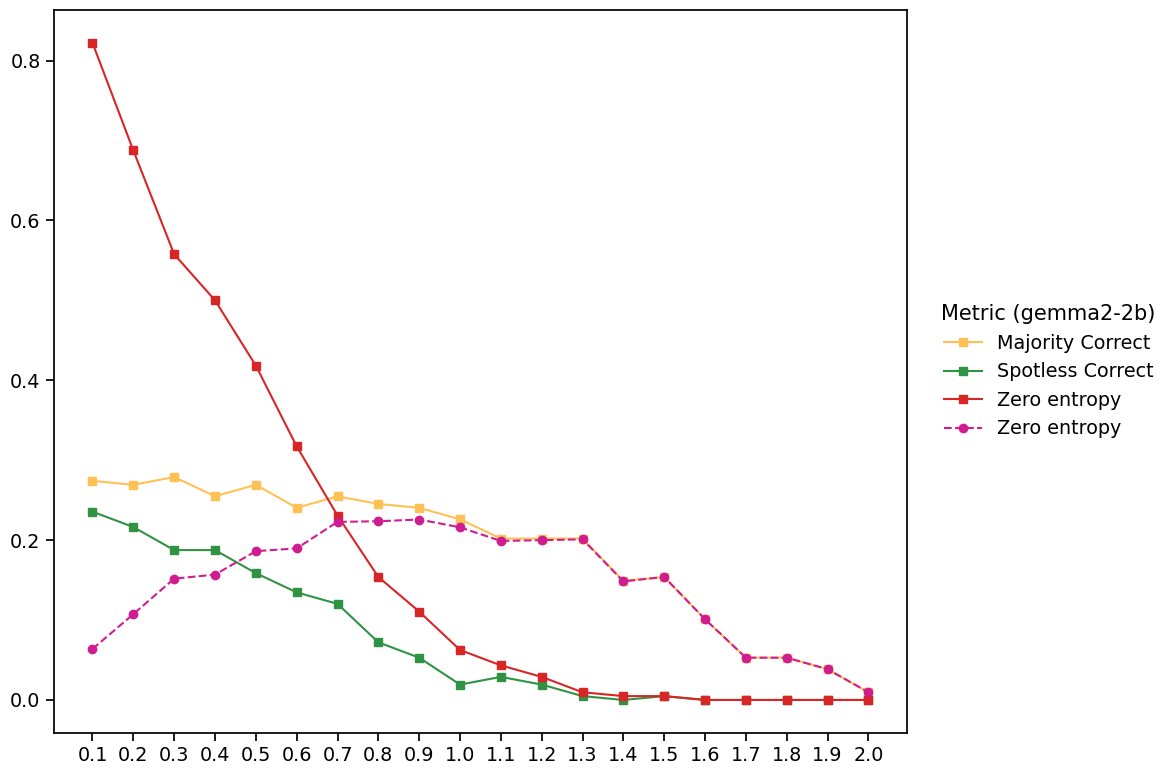

In [130]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from palettable.tableau import TrafficLight_9
from palettable.cartocolors.qualitative import Bold_10
opal = Bold_10.mpl_colors

palette = TrafficLight_9.mpl_colors

# Prepare the data
answers_data = d_melted[d_melted["Metric"] == "answers_entropy_norm"]

correct_data = d_melted[d_melted["Metric"] == "correct"]

# Summary lines
total_counts = d.groupby('temperature').size()
maj_vals = (d.groupby('temperature').majority_correct.sum() / total_counts).reindex(sorted(d["temperature"].unique())).replace(np.nan,0).values
spot_vals = (d[d.correct == 1.].groupby('temperature').correct.sum() / total_counts).reindex(sorted(d["temperature"].unique())).replace(np.nan,0).values
# never_vals = (d[(d.correct == 0.) & (d.answers_entropy_norm==0.)].groupby('temperature').correct.size() / total_counts).reindex(sorted(d["temperature"].unique())).values
never_vals = (d[(d.answers_entropy_norm==0.)].groupby('temperature').correct.size() / total_counts).reindex(sorted(d["temperature"].unique())).replace(np.nan,0).values

# rapporto tra valori sopra zona rossa e valori tra rossa e verde
heuristic = ((1 - never_vals) / (1 - spot_vals)) * maj_vals

temperature_order = sorted(d["temperature"].unique())
x_pos = temperature_order  # Use actual temperature values

# Set up figure and dual y-axes
fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.plot(x_pos, maj_vals, marker='s', linestyle='-', color=palette[4], label='Majority Correct')
ax1.plot(x_pos, spot_vals, marker='s', linestyle='-', color=palette[2], label='Spotless Correct')
ax1.plot(x_pos, never_vals, marker='s', linestyle='-', color=palette[3], label='Zero entropy')

ax1.plot(x_pos, heuristic, marker='o', linestyle='--', color=opal[8], label='Zero entropy')

handles1, labels1 = plt.gca().get_legend_handles_labels()
plt.legend(
    handles=handles1,
    title="Metric (" + inpath + ")",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False
)
plt.xticks(ticks=temperature_order)  # Labels will match ticks automatically

# plt.ylim(0,1)
plt.tight_layout()

plt.savefig("temperature_jam_" + inpath + ".pdf", format="pdf", bbox_inches="tight", dpi=600)

plt.show()

/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_14720/1343895993.py:39: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(


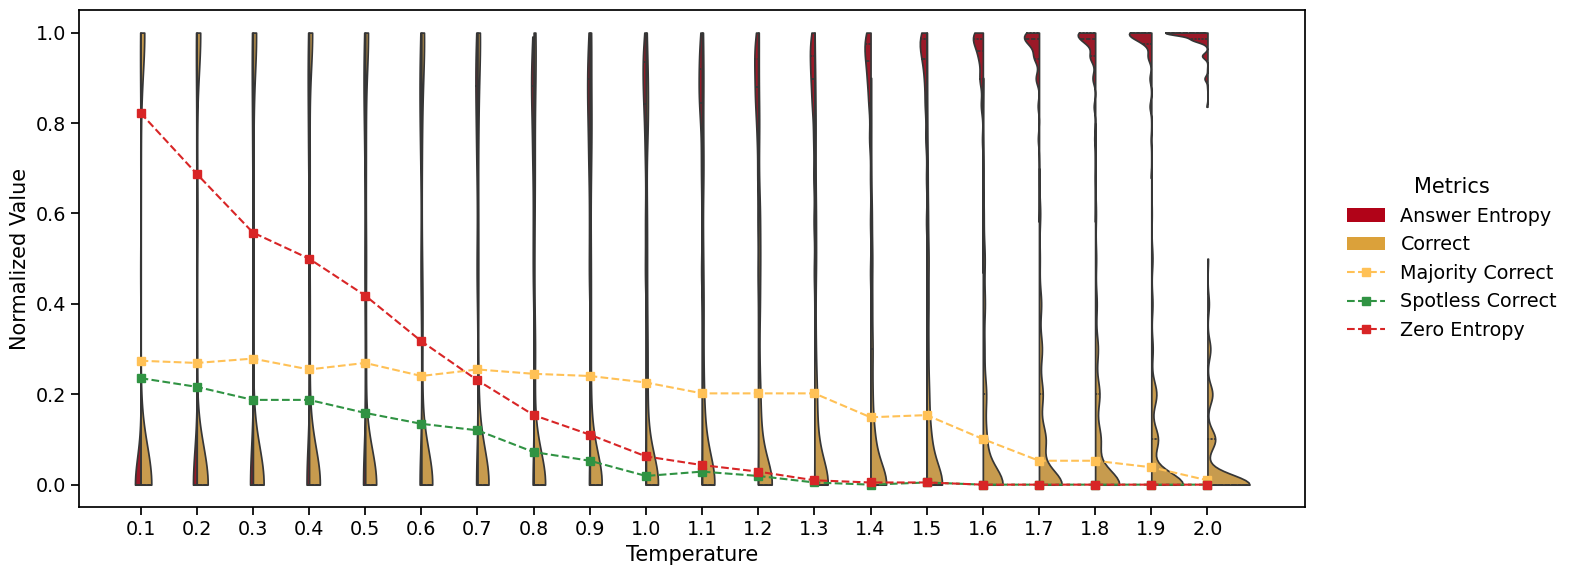

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from palettable.tableau import TrafficLight_9

palette = TrafficLight_9.mpl_colors

# --- Normalize entropy to 0–1 range ---
# We'll create a copy of d_melted where "answers_entropy_norm" values are rescaled
d_melted_scaled = d_melted.copy()

# Only scale entropy values
entropy_mask = d_melted_scaled["Metric"] == "answers_entropy_norm"
entropy_values = d_melted_scaled.loc[entropy_mask, "Value"]
entropy_min = entropy_values.min()
entropy_max = entropy_values.max()

# Min-max scale
d_melted_scaled.loc[entropy_mask, "Value"] = (
    (entropy_values - entropy_min) / (entropy_max - entropy_min)
)

# --- Compute summary lines (already in 0-1 range) ---
total_counts = d.groupby('temperature').size()
maj_correct_norm = d.groupby('temperature').majority_correct.sum() / total_counts
spotless_correct_norm = d[d.correct == 1.].groupby('temperature').correct.sum() / total_counts
zero_entropy_norm = d[(d.answers_entropy_norm==0.)].groupby('temperature').correct.size() / total_counts

temperature_order = sorted(d["temperature"].unique())
x_pos = range(len(temperature_order))

maj_vals = maj_correct_norm.reindex(temperature_order).replace(np.nan,0).values
spot_vals = spotless_correct_norm.reindex(temperature_order).replace(np.nan,0).values
zero_vals = zero_entropy_norm.reindex(temperature_order).replace(np.nan,0).values

# --- Plot ---
plt.figure(figsize=(16, 6))

sns.violinplot(
    data=d_melted_scaled,
    x="temperature",
    y="Value",
    hue="Metric",
    split=True,
    inner="quart",
    density_norm="area",
    cut=0,
    bw=0.2,
    width=1.5,
    palette=palette[:2]  # Use only first two colors for the violins
)

# Overlay normalized summary lines
plt.plot(x_pos, maj_vals, marker='s', linestyle='--', color=palette[4], label='Majority Correct')
plt.plot(x_pos, spot_vals, marker='s', linestyle='--', color=palette[2], label='Spotless Correct')
plt.plot(x_pos, zero_vals, marker='s', linestyle='--', color=palette[3], label='Never Correct')

# X-axis formatting
plt.xticks(ticks=x_pos, labels=temperature_order)
plt.xlabel("Temperature")
plt.ylabel("Normalized Value")

# Combine legends properly
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor=palette[0], label='Answer Entropy'),
    Patch(facecolor=palette[1], label='Correct'),
    Line2D([0], [0], marker='s', linestyle='--', color=palette[4], label='Majority Correct'),
    Line2D([0], [0], marker='s', linestyle='--', color=palette[2], label='Spotless Correct'),
    Line2D([0], [0], marker='s', linestyle='--', color=palette[3], label='Zero Entropy')
]

plt.legend(
    handles=legend_elements,
    title="Metrics",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False
)

plt.tight_layout()
plt.savefig("temperature_viol_" + inpath + ".pdf", format="pdf", bbox_inches="tight", dpi=600)
plt.show()